In [1]:
%load_ext rpy2.ipython

$\gamma_i$: relative risk; $q_i$: allel frequency

###Under H0: $\gamma = 1$

$q \sim Gamma(\rho_0, \nu_0)$    OR     $q \sim Gamma(\bar{q_0}\nu_0, \nu_0 )$ 

###Under H1:

$q \sim Gamma(\rho_1, \nu_1)$    OR    $q_i \sim Gamma(\bar{q_1}v_1, v_1)$

$\gamma_i \sim Gamma(\bar{\gamma}\beta, \beta)$

###Hyperparameters

$\phi_1 = (\bar{\gamma}, \beta, \bar{q_1}, v_1)$

$\phi_0 = (\bar{q_0}, v_0)$

###The rate of a specific type of mutation:

$c(\mu_{LoF}, \mu_{Mis3}) = c(0.074, 0.32)$  Table S3 (http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1003671)

###Mutation rate for each gene (in Methods)

Use gene length + base content as [De novo mutations revealed by whole-exome sequencing are strongly associated with autism](http://www.nature.com/nature/journal/v485/n7397/full/nature10945.html)

======
##Improvement in Nature 13772

###Two different prior distributions for $\gamma$: de novo and inherited variants

$\gamma_d \sim Gamma(\bar{\gamma_d} \beta_d, \beta_d) \quad \gamma \sim Gamma(\bar{\gamma} \beta, \beta) $

=> Change in BFs

### $B = \frac{P(x|H_1)}{P(x|H_0} = \frac{P(x_d|H_1) \times P(x_1, x_0 | H_1)}{P(x_d|H_0) \times P(x_1, x_0 | H_0)} = B_d \times B_i. $

In [135]:
%%R

source("scripts/TADA/TADA.R")

#################################################################
# Application of TADA
#################################################################

# Model parameters: two categories of mutations - LoF and mis3 mutations ("probably damaging" by PolyPhen2)
mu.frac <- c(0.074, 0.32) ##Mutation rates for specific category
#gamma.mean.dn <- c(20, 4.7)
gamma.mean.dn <- c(14, 2.33)
#beta.dn <- c(1,1)
beta.dn <- c(4.8, 2.325)


gamma.mean.CC <- c(2.3, 1.00)

#gamma.mean.CC <- c(2.0, 1.00)


beta.CC <- c(4.0, 1000)
rho1 <- c(0.1, 0.5)
nu1 <- c(200, 100)
rho0 <- c(0.1, 0.5)
nu0 <- c(200, 100)
hyperpar <- as.array(rbind(gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0))
l <- 100
#pi0 <- 0.94 # the fraction of non-risk genes
pi0 <- 1 - 0.07419

hyperpar

               [,1]     [,2]
gamma.mean.dn  14.0    2.330
beta.dn         4.8    2.325
gamma.mean.CC   2.3    1.000
beta.CC         4.0 1000.000
rho1            0.1    0.500
nu1           200.0  100.000
rho0            0.1    0.500
nu0           200.0  100.000


In [136]:
%%R
# ASC (Autism Sequencing Consortium) data
# The file name contains the sample size information
# The only relevant counts are dn.LoF and dn.mis3
#data <- read.csv("data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header=TRUE, as.is=TRUE)
#ntrio <- 2231  # number of trios
#ncase <- 1601  # number of cases
#nctrl <- 5397  # number of controls
#ntrans <- 1333 # number of subjects with transmission data
#N <- list(dn=ntrio, ca=ntrans+ncase, cn=ntrans+nctrl)

data <- read.csv("data/nature_aut_id_epi.merged.txt", header = TRUE, sep = " ")
#source("TADA/TADA.R")
ntrio <- 2270 + 32 + 0 + 2508 ##AUT
ntrio <- ntrio + 0 + 356 #add EPI
ntrio <- ntrio + 100 + 0 + 41 + 51 ##add ID samples
ncase <- 1601 #Only from AUT paper
nctrl <- 5397  #Only from AUT paper
ntrans <- 1298 ##Check this information, Only use transmitted information from AUT paper nature13772
#ntrans <- ntrio

N <- list(dn=ntrio, ca=ntrans+ncase, cn=ntrans+nctrl)


print(head(data))

sum(unlist(N))

    Gene mut.rate dn.LoF case.LoF ctrl.LoF trans.LoF ntrans.LoF dn.mis3
1   A1BG 2.36e-05      0        0        1         0          0       0
2   A1CF 2.17e-05      0        1        2         1          1       0
3  A2LD1 6.09e-06      0        0        0         0          0       0
4    A2M 5.64e-05      0        1        5         1          0       1
5  A2ML1 5.70e-05      0        3       16         2          6       1
6 A4GALT 2.42e-05      0        0        2         1          0       0
  case.mis3 ctrl.mis3 trans.mis3 ntrans.mis3     BF.dn         BF qvalue.dn
1         0         4          7           3 0.7641762 0.54953615 0.9308429
2         0         7          3           7 0.7799631 0.75499580 0.9294060
3         0         0          0           0 0.9322423 0.50824558 0.8592336
4         4        22          6           6 0.5305202 0.29674445 0.9388012
5         5        30          6          10 0.5270516 0.05155223 0.9388542
6         1         5          2        

###Total counts of variants

$N_d$: number of trios

$N_0 = N_{cn} + N_d \quad N_1 = N_{cs} + N_d$

$X_d \sim Pois(2\mu\lambda N_d) \quad X_1 \sim Pois(q\lambda N_1) \quad X_0 \sim Pois(q N_0)$

$X_0 = X_u + X_{cn}$: total number of LoF variants in the controls + the number of nontransmitted LoF variants

$X_1 = X_t + X_{cs}$: total number of LoF variants in the case + the number of transmitted LoF variants

###The likelihood function is the product of the three individual probabilities

$x = (x_d, x_1, x_0)$: count data for a gene to be tested

$P(x_d, x_1, x_0|q, \lambda) = Pois(x_d|2\mu\lambda N_d).Pois(x_1|q\lambda N_1) . Pois(x_0|qN_0)$

###






##Bayes factor for any gene:

$H_1: \gamma \neq 1 \quad vs. \quad H_0: \gamma = 1$

$\phi_1 = (\bar{\gamma}, \beta, \bar{q_1}, \nu_1)$: the prior parameters of $H_1$

$\phi_0 = (\bar{q_0}, \nu_0) $: the prior parameters of $H_0$

$P(x_i|H_0) = \int p(x_i|q_i, \gamma = 1)p(q_i|H_0)dq_i$

$P(x_i|H_1 = \int p(x_i|q_i, \gamma) p(q_i|H_1) p(\gamma_i |H_1) dq_i d\gamma_i$

Solve the marginal likelihood of all the data, as a function of the hyperparameters $(\phi_1, \phi_0)$

### $P(x|\phi_1, \phi_0) = \prod_{i=1}^{n}\left[ \pi P(x_i|H_1) + (1 - \pi)P(x_i|H_0)\right]$ 

$\pi$: the proportion of risk genes

Calculate the Bayes factor for each gene:

###$B_i = \frac{P(x_i|H_1)}{P(x_i|H_0)}$



###For multiple types of mutations (assumming that the data of each type of mutation are independent of each other)

$B = B_{LoF}[w.B_{Mis3} + (1 - w)]$

w = 0.55

In [137]:
%%R

# Running TADA
counts <- as.array(cbind(data$dn.LoF, ##Xd
                         data$case.LoF+data$trans.LoF, data$ctrl.LoF+data$ntrans.LoF, ##X1, X0
                         data$dn.mis3, 
                         data$case.mis3+data$trans.mis3, data$ctrl.mis3+data$ntrans.mis3))
head(counts)

     [,1] [,2] [,3] [,4] [,5] [,6]
[1,]    0    0    1    0    7    7
[2,]    0    2    3    0    3   14
[3,]    0    0    0    0    0    0
[4,]    0    2    5    1   10   28
[5,]    0    5   22    1   11   40
[6,]    0    1    2    0    3    6


In [138]:
%%R
#Running TADA
rs <- TADA(counts, N, data$mut.rate, mu.frac, hyperpar)
data$BF <- rs$BF.total


In [139]:
%%R
# Estimating p-values of BFs (this is optional and slow)
rsp <- TADAp(counts, N, data$mut.rate, mu.frac, hyperpar, l=100)
data$pval.TADA <- rsp$pval


In [140]:
%%R
# FDR estimation
data <- data[order(-data$BF),]
data$qvalue <- Bayesian.FDR(data$BF, pi0)$FDR
write.csv(data, "data/ext_TADA_results.csv", row.names=FALSE)



In [141]:
%%R
head(data)

         Gene mut.rate dn.LoF case.LoF ctrl.LoF trans.LoF ntrans.LoF dn.mis3
14230   SCN2A 7.40e-05      9        2        0         0          0      12
15819 SYNGAP1 6.55e-05      8        0        0         0          0       3
3312     CHD8 9.25e-05      7        4        0         0          0       2
14228   SCN1A 7.50e-05      4        1        0         0          0       7
3306     CHD2 7.02e-05      6        1        0         0          0       1
940    ARID1B 9.02e-05      6        0        0         0          0       1
      case.mis3 ctrl.mis3 trans.mis3 ntrans.mis3        BF.dn           BF
14230         4        26          5           5 6.154767e+08 4.745777e+17
15819         3         6          4           2 2.315971e+08 6.743925e+09
3312          7        29          4           2 6.350230e+04 1.310238e+09
14228        11        16          9           5 9.478442e+00 6.875045e+07
3306          7         8          5           3 1.950725e+00 1.055109e+07
940        

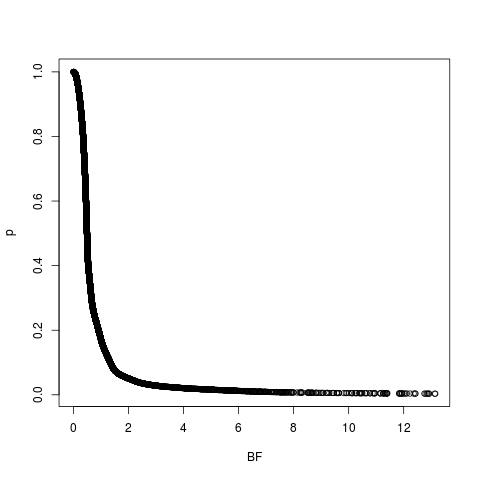

In [142]:
%%R
tempData <- data.frame(data$BF, data$pval.TADA)

tempData <- tempData[tempData[, 1] < quantile(tempData[, 1], 0.99), ]

plot(tempData[, 1], tempData[, 2], xlab = "BF", ylab = "p")

###Extract genes whose FDRs < 0.1

In [143]:
%%bash
cat data/ext_TADA_results.csv |awk -F"," '$(NF-1)<0.1'|\
    awk -F"," '{print $1}'|sed 's/"//g'|grep -v "Gene" |sort > data/list.genesWithNewPiFDR01.txt
    
cat data/list.genesWithNewPiFDR01.txt|wc -l
cat data/list.genesWithNewPiFDR01.txt|tr "\n" " "

80
ADNP ANK2 ARID1B ASXL3 BCL11A CACNA2D3 CDC42BPB CHD2 CHD8 CTNNB1 CTTNBP2 DDX3X DIP2A DNMT3A DSCAM DYRK1A ETFB FOXP1 GABRB3 GATAD2B GIGYF1 GRIN2B HNRNPU IL17RA ILF2 IQSEC2 KATNAL2 KCNQ2 KDM5B KDM6B MBD5 MED13L MFRP MIB1 MLL MLL3 MLL5 MTHFS MYH10 MYT1L NBEA NCKAP1 NEDD9 NINL OR52M1 P2RX5 PHF2 PHF21A PHIP POGZ PSD3 PTEN RAI1 RALGAPB RANBP17 SCN1A SCN2A SETBP1 SETD5 SLC35A2 SLC6A1 SMURF1 SPAST STXBP1 SUCLA2 SUV420H1 SYNGAP1 TBR1 TCF4 TCF7L2 TMEM39B TNRC6B TRIO TTLL3 TUBA1A WAC WDFY3 WDR45 ZC3H4 ZNF559 

###Intersect this gene set with the 33 genes in AUT

In [144]:
%%bash
join -1 1 -2 1 data/list.genesWithNewPiFDR01.txt data/list.33genes.FDR0.1.txt|wc -l

25


####Test with known risk genes from three diseases: ASD + EPI + ID

In [94]:
%%R
#################################################################
# Application of TADA
#################################################################

# Model parameters: two categories of mutations - LoF and mis3 mutations ("probably damaging" by PolyPhen2)
mu.frac <- c(0.074, 0.32) ##Mutation rates for specific category
#gamma.mean.dn <- c(20, 4.7)
gamma.mean.dn <- c(14, 2.33)
#beta.dn <- c(1,1)
beta.dn <- c(4.8, 2.325)


gamma.mean.CC <- c(2.3, 1.00)
beta.CC <- c(4.0, 1000)
rho1 <- c(0.1, 0.5)
nu1 <- c(200, 100)
rho0 <- c(0.1, 0.5)
nu0 <- c(200, 100)
hyperpar1 <- as.array(rbind(gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0))
l <- 100
#pi0 <- 0.94 # the fraction of non-risk genes
pi0 <- 1 - 0.07419


In [100]:
%%R
#Running TADA
rs <- TADA(counts, N, data$mut.rate, mu.frac, hyperpar1)
data$BF <- rs$BF.total
# Estimating p-values of BFs (this is optional and slow)

#rsp1 <- TADAp(counts, N, data1$mut.rate, mu.frac, hyperpar1, l=100)
#data1$pval.TADA <- rsp1$pval




In [101]:
%%R
# FDR estimation
data <- data[order(-data$BF),]
data$qvalue <- Bayesian.FDR(data$BF, pi0)$FDR



In [102]:
%%R
write.csv(data1, "data/ext_TADA_results_usingThreeGeneSets.csv", row.names=FALSE)

getwd()

[1] "/usr/data/extTADA"


In [103]:
%%bash
cat data/ext_TADA_results_usingThreeGeneSets.csv |awk -F"," '$(NF-1)<0.1'|\
    awk -F"," '{print $1}'|sed 's/"//g'|grep -v "Gene" |\
    sort > data/list.genesWithNewPiFDR01.usingThreeGeneSets.txt
    
cat data/list.genesWithNewPiFDR01.usingThreeGeneSets.txt|wc -l
cat data/list.genesWithNewPiFDR01.usingThreeGeneSets.txt|tr "\n" " "


105
ACTL6B AIFM3 ARHGEF10L ARL5C ASS1 ATAD2 BAMBI BEND3 BPIFB3 BRIX1 C12orf68 C1orf27 C20orf197 C21orf33 C2CD4A C2orf53 C3orf26 C3orf79 C6orf72 CCL18 CD27 CD300A CD9 CLRN3 CLTCL1 CYP4F8 DLG2 DUSP28 DYNC1LI2 EDARADD EIF2S1 EIF4E1B ESPNL EXOC7 F2R FAM178B FAM26F FAM55B FGFR1 GALNT2 GGTLC2 GJD2 GSTT1 GUCY2C HINT1 HIST1H2AJ HLA-DPB1 HN1L HSPA1A IHH KATNAL2 KCNK2 KCNN1 KIAA0226 KIF14 KRTAP20-2 KRTAP21-1 LITAF LRTOMT MAN2B2 METTL20 MGP MKL1 MPPED2 MRC1 MRPL2 NDUFA3 NIPSNAP3A NKX6-2 NTPCR OGDHL OR10A2 OR2T1 OVCH1 PCDHAC1 PDHA2 PHOX2B PLA2G4A PLA2G4C PNMA1 PRKAG3 RABGAP1L RDH10 RHOG RNASEH2A SBDS SEMA4B SLC30A2 SLC9C2 SMPX SPDYE2 SRP19 SUZ12 TCF23 TMEM126B TMEM176B TNFRSF12A TNFRSF6B TSPYL5 UNC5B VAX1 WBSCR22 ZDHHC19 ZNF714 ZXDC 

In [104]:
%%bash
join -1 1 -2 1 data/list.genesWithNewPiFDR01.usingThreeGeneSets.txt data/list.33genes.FDR0.1.txt|wc -l

1


In [22]:
#!gist -p Re_run_TADA_exTADA.ipynb

In [23]:
!gist -u https://gist.github.com/40eb110d8ac72b91d6e9 Re_run_TADA_exTADA.ipynb

https://gist.github.com/40eb110d8ac72b91d6e9
